# Score-based Generative Modeling with SDEs (Simple examples)

In [1]:
import os

'/Users/hyemin/Documents/source_code/Proximal_generative_models/scripts/sgm_simple-benjamin'

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np
import pickle

Basic parameters

In [3]:
learning_rate = 1e-3 # learning rate for training neural network
batch_size = 10000  # batch size during training of neural network
N_samples = 10000
epochs = 100000   # Number of training epochs for the neural network
sigma_max = 100.0 # 100 for df=1.0
sigma_min = 0.01  # 0.01 for df=1.0
T = 1    # Forward simulation time in the forward SDE (fixed)
dataset = 'student-t' # Dataset choice, see toy_data for full options of toy datasets 
df = 3.0

We first initialize the neural net that models the score function. 

In [4]:
## Model construction

class DenoisingModel(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32
        
        # data and timestep
        self.fc1 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.activation3 = nn.GELU()
        
        self.fc4 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.activation4 = nn.GELU()
        self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        self.activation5 = nn.GELU()
        self.fc6 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.activation6 = nn.GELU()
        
        self.fc7 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc7.weight)
        self.activation7 = nn.GELU()
        self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc8.weight)
        self.activation8 = nn.GELU()
        self.fc9 = nn.Linear(int(hidden_units), 2, bias=True)
        nn.init.xavier_uniform_(self.fc9.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = self.fc9(x)
        
        return x
      
scorenet = DenoisingModel()
print(scorenet)
optimizer = optim.Adam(scorenet.parameters(), lr=learning_rate)

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=32, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=32, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=32, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)


Define loss functions. These loss functions assume that the forward process is a standard OU process dx = -x/2 dt + dW. The choice of \lambda(t) in the SGM objective function is equal to 1 (the constant in front of the dW term). 

In [5]:
# Loss function -- we use the denoising diffusions objective function
# Scorenet is the score model, samples are the training samples, Tmin/Tmax are the time interval that is being trained on, and eps is so that Tmin is not sampled. 

def time_dsm_score_estimator(scorenet,samples,sigma_min,sigma_max,Tmin,Tmax,eps):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

    # Add noise to the training samples
    z = torch.randn_like(samples)
    sigmas = sigma_min * (sigma_max/sigma_min)**((t - Tmin)/(Tmax - Tmin))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = z * sigmas
    #tenlarge = t.repeat(2,1).T
    perturbed_samples = samples + noise

    # Evaluate score and marginal score on the perturbed samples
    #target = - 1/ (sigmas ** 2) * (noise)
    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)

    # Evaluate the loss function 
    #target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores * sigmas + z) ** 2).sum(dim = -1) 

    return loss.mean(dim = 0)


# Loss function
# This is for if you have a specific mesh for the time interval you would like the network to train on. 
def deterministic_time_dsm_score_estimator(scorenet,samples,t):

    loss = 0
    for ii in range(len(t)-1):

        # Add noise to the training samples
        sigmas = torch.sqrt(1 - torch.exp(-t[ii]))
        noise = torch.randn_like(samples) * sigmas
        perturbed_samples = samples * torch.exp(-0.5 * t[ii]) + noise

        # Evaluate score and marginal score on perturbed samples
        target = - 1/ (sigmas ** 2) * (noise)
        score_eval_samples = torch.cat((t[ii].repeat(perturbed_samples.shape[0],1),perturbed_samples),1)
        scores = scorenet(score_eval_samples)

        # Evaluate loss function at this particular t[ii]
        target = target.view(target.shape[0],-1)
        scores = scores.view(scores.shape[0],-1)
        loss_vec = 0.5 * ((scores-target) ** 2).sum(dim = -1) 
        loss = loss + (t[ii+1]-t[ii])*loss_vec.mean(dim = 0)

    return loss


Training the score network

In [6]:
# Training the score network
# sample toy_data
#p_samples_all = toy_data.inf_train_gen(dataset, N_samples)
p_samples = toy_data.inf_train_gen(dataset, N_samples, misc_params={'df':df})

for step in range(epochs):
    #for i in range(int(N_samples//batch_size)):
    #    p_samples = p_samples_all[i*batch_size:(i+1)*batch_size,:]
    samples = torch.tensor(p_samples).to(dtype = torch.float32)

    # evaluate loss function and gradient
    loss = time_dsm_score_estimator(scorenet,samples,sigma_min, sigma_max, 0,T,eps = 0.0005)
    optimizer.zero_grad()
    loss.backward()

    # Update score network
    optimizer.step()

    if not step%100:
        print(loss,step)




tensor(82.0827, grad_fn=<MeanBackward1>) 0
tensor(0.9664, grad_fn=<MeanBackward1>) 100
tensor(0.9215, grad_fn=<MeanBackward1>) 200
tensor(0.9250, grad_fn=<MeanBackward1>) 300
tensor(0.8984, grad_fn=<MeanBackward1>) 400
tensor(0.8522, grad_fn=<MeanBackward1>) 500
tensor(0.8628, grad_fn=<MeanBackward1>) 600
tensor(0.8535, grad_fn=<MeanBackward1>) 700
tensor(0.8306, grad_fn=<MeanBackward1>) 800
tensor(0.8383, grad_fn=<MeanBackward1>) 900
tensor(0.8351, grad_fn=<MeanBackward1>) 1000
tensor(0.8329, grad_fn=<MeanBackward1>) 1100
tensor(0.8321, grad_fn=<MeanBackward1>) 1200
tensor(0.8367, grad_fn=<MeanBackward1>) 1300
tensor(0.8556, grad_fn=<MeanBackward1>) 1400
tensor(0.8481, grad_fn=<MeanBackward1>) 1500
tensor(0.8310, grad_fn=<MeanBackward1>) 1600
tensor(0.8489, grad_fn=<MeanBackward1>) 1700
tensor(0.8295, grad_fn=<MeanBackward1>) 1800
tensor(0.8477, grad_fn=<MeanBackward1>) 1900
tensor(0.8212, grad_fn=<MeanBackward1>) 2000
tensor(0.8440, grad_fn=<MeanBackward1>) 2100
tensor(0.8440, grad_f

tensor(0.5579, grad_fn=<MeanBackward1>) 18100
tensor(0.5683, grad_fn=<MeanBackward1>) 18200
tensor(0.5694, grad_fn=<MeanBackward1>) 18300
tensor(0.5770, grad_fn=<MeanBackward1>) 18400
tensor(0.5460, grad_fn=<MeanBackward1>) 18500
tensor(0.5573, grad_fn=<MeanBackward1>) 18600
tensor(0.5559, grad_fn=<MeanBackward1>) 18700
tensor(0.5666, grad_fn=<MeanBackward1>) 18800
tensor(0.5639, grad_fn=<MeanBackward1>) 18900
tensor(0.5586, grad_fn=<MeanBackward1>) 19000
tensor(0.5611, grad_fn=<MeanBackward1>) 19100
tensor(0.5758, grad_fn=<MeanBackward1>) 19200
tensor(0.5699, grad_fn=<MeanBackward1>) 19300
tensor(0.5881, grad_fn=<MeanBackward1>) 19400
tensor(0.5578, grad_fn=<MeanBackward1>) 19500
tensor(0.5766, grad_fn=<MeanBackward1>) 19600
tensor(0.5675, grad_fn=<MeanBackward1>) 19700
tensor(0.5616, grad_fn=<MeanBackward1>) 19800
tensor(0.5658, grad_fn=<MeanBackward1>) 19900
tensor(0.5538, grad_fn=<MeanBackward1>) 20000
tensor(0.5580, grad_fn=<MeanBackward1>) 20100
tensor(0.5574, grad_fn=<MeanBackwa

tensor(0.5521, grad_fn=<MeanBackward1>) 36000
tensor(0.5521, grad_fn=<MeanBackward1>) 36100
tensor(0.5514, grad_fn=<MeanBackward1>) 36200
tensor(0.5430, grad_fn=<MeanBackward1>) 36300
tensor(0.5477, grad_fn=<MeanBackward1>) 36400
tensor(0.5849, grad_fn=<MeanBackward1>) 36500
tensor(0.5614, grad_fn=<MeanBackward1>) 36600
tensor(0.5523, grad_fn=<MeanBackward1>) 36700
tensor(0.5500, grad_fn=<MeanBackward1>) 36800
tensor(0.5473, grad_fn=<MeanBackward1>) 36900
tensor(0.5550, grad_fn=<MeanBackward1>) 37000
tensor(0.5293, grad_fn=<MeanBackward1>) 37100
tensor(0.5462, grad_fn=<MeanBackward1>) 37200
tensor(0.5652, grad_fn=<MeanBackward1>) 37300
tensor(0.5596, grad_fn=<MeanBackward1>) 37400
tensor(0.6648, grad_fn=<MeanBackward1>) 37500
tensor(0.5963, grad_fn=<MeanBackward1>) 37600
tensor(0.5812, grad_fn=<MeanBackward1>) 37700
tensor(0.5659, grad_fn=<MeanBackward1>) 37800
tensor(0.6096, grad_fn=<MeanBackward1>) 37900
tensor(0.5862, grad_fn=<MeanBackward1>) 38000
tensor(0.5602, grad_fn=<MeanBackwa

tensor(0.5392, grad_fn=<MeanBackward1>) 53900
tensor(0.5487, grad_fn=<MeanBackward1>) 54000
tensor(0.5284, grad_fn=<MeanBackward1>) 54100
tensor(0.5346, grad_fn=<MeanBackward1>) 54200
tensor(0.5581, grad_fn=<MeanBackward1>) 54300
tensor(0.5471, grad_fn=<MeanBackward1>) 54400
tensor(0.5325, grad_fn=<MeanBackward1>) 54500
tensor(0.5514, grad_fn=<MeanBackward1>) 54600
tensor(0.5373, grad_fn=<MeanBackward1>) 54700
tensor(0.5336, grad_fn=<MeanBackward1>) 54800
tensor(0.5369, grad_fn=<MeanBackward1>) 54900
tensor(0.5375, grad_fn=<MeanBackward1>) 55000
tensor(0.5425, grad_fn=<MeanBackward1>) 55100
tensor(0.5381, grad_fn=<MeanBackward1>) 55200
tensor(0.5517, grad_fn=<MeanBackward1>) 55300
tensor(0.5417, grad_fn=<MeanBackward1>) 55400
tensor(0.5219, grad_fn=<MeanBackward1>) 55500
tensor(0.5391, grad_fn=<MeanBackward1>) 55600
tensor(0.5406, grad_fn=<MeanBackward1>) 55700
tensor(0.5550, grad_fn=<MeanBackward1>) 55800
tensor(0.5293, grad_fn=<MeanBackward1>) 55900
tensor(0.5500, grad_fn=<MeanBackwa

tensor(0.5343, grad_fn=<MeanBackward1>) 71800
tensor(0.5375, grad_fn=<MeanBackward1>) 71900
tensor(0.5401, grad_fn=<MeanBackward1>) 72000
tensor(0.5411, grad_fn=<MeanBackward1>) 72100
tensor(0.5397, grad_fn=<MeanBackward1>) 72200
tensor(0.5318, grad_fn=<MeanBackward1>) 72300
tensor(0.5408, grad_fn=<MeanBackward1>) 72400
tensor(0.5311, grad_fn=<MeanBackward1>) 72500
tensor(0.5486, grad_fn=<MeanBackward1>) 72600
tensor(0.5321, grad_fn=<MeanBackward1>) 72700
tensor(0.5379, grad_fn=<MeanBackward1>) 72800
tensor(0.5278, grad_fn=<MeanBackward1>) 72900
tensor(0.5458, grad_fn=<MeanBackward1>) 73000
tensor(0.5255, grad_fn=<MeanBackward1>) 73100
tensor(0.5394, grad_fn=<MeanBackward1>) 73200
tensor(0.5460, grad_fn=<MeanBackward1>) 73300
tensor(0.5275, grad_fn=<MeanBackward1>) 73400
tensor(0.5401, grad_fn=<MeanBackward1>) 73500
tensor(0.5452, grad_fn=<MeanBackward1>) 73600
tensor(0.5464, grad_fn=<MeanBackward1>) 73700
tensor(0.5268, grad_fn=<MeanBackward1>) 73800
tensor(0.5376, grad_fn=<MeanBackwa

tensor(0.5406, grad_fn=<MeanBackward1>) 89700
tensor(0.5286, grad_fn=<MeanBackward1>) 89800
tensor(0.5362, grad_fn=<MeanBackward1>) 89900
tensor(0.5239, grad_fn=<MeanBackward1>) 90000
tensor(0.5320, grad_fn=<MeanBackward1>) 90100
tensor(0.5406, grad_fn=<MeanBackward1>) 90200
tensor(0.5540, grad_fn=<MeanBackward1>) 90300
tensor(0.5337, grad_fn=<MeanBackward1>) 90400
tensor(0.5372, grad_fn=<MeanBackward1>) 90500
tensor(0.5343, grad_fn=<MeanBackward1>) 90600
tensor(0.5365, grad_fn=<MeanBackward1>) 90700
tensor(0.5506, grad_fn=<MeanBackward1>) 90800
tensor(0.5300, grad_fn=<MeanBackward1>) 90900
tensor(0.5451, grad_fn=<MeanBackward1>) 91000
tensor(0.5375, grad_fn=<MeanBackward1>) 91100
tensor(0.5353, grad_fn=<MeanBackward1>) 91200
tensor(0.5391, grad_fn=<MeanBackward1>) 91300
tensor(0.5332, grad_fn=<MeanBackward1>) 91400
tensor(0.5221, grad_fn=<MeanBackward1>) 91500
tensor(0.5291, grad_fn=<MeanBackward1>) 91600
tensor(0.5269, grad_fn=<MeanBackward1>) 91700
tensor(0.5442, grad_fn=<MeanBackwa

SDE simulation functions

In [7]:
# This is the solving the VE process exactly given deterministic initial conditions
def ve_dynamics(init, sigma_min, sigma_max, T=1.0):
    init = init + sigma_max * torch.randn_like(init)
    return init
    
def reverse_sde(score, init, sigma_min, sigma_max, T=1.0, lr=0.01):
    step = int(T/lr)
    for i in range(step,-1,-1):
        evalpoint = torch.cat(((torch.tensor(lr*i/T)).repeat(init.shape[0],1),init),1)
        drift = torch.zeros_like(evalpoint)
        sigma = sigma_min *(sigma_max/sigma_min)**(i*lr/T)
        diffusion = sigma * torch.sqrt(2*(torch.log(sigma_max)-torch.log(sigma_min)))
        
        init = init + lr  * diffusion**2 * score(evalpoint).detach() 
        init = init + diffusion * torch.randn_like(init) * np.sqrt(lr)
    return init



# The following is the deterministic ODE flow that can also sample from the target distribution

def reverse_ode_flow(score,init, sigma_min, sigma_max, T=1.0, lr = 0.01):
    step = int(T/lr)
    for i in range(step,-1,-1):
        evalpoint = torch.cat(((torch.tensor(lr*i/T)).repeat(init.shape[0],1),init),1)
        sigma = sigma_min *(sigma_max/sigma_min)**(i*lr/T)
        diffusion = sigma * torch.sqrt(2*(torch.log(sigma_max)-torch.log(sigma_min)))
        
        init = init + lr/2* diffusion**2 * score(evalpoint).detach() 
    return init

Sample using the score network 

In [8]:
# Denoising the normal distribution 
samples_lang = torch.randn(10000, 2)*sigma_max # * (right_bound - left_bound) + left_bound
samples_lang = reverse_sde(scorenet, samples_lang, torch.tensor(sigma_min), torch.tensor(sigma_max)).detach().numpy()




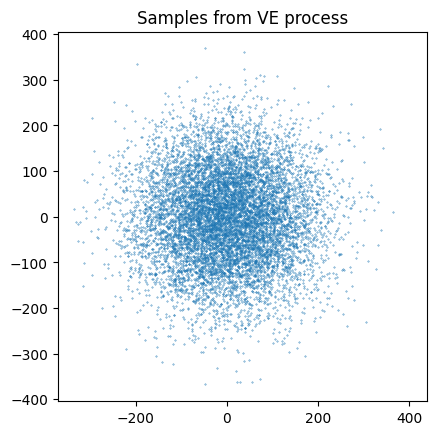

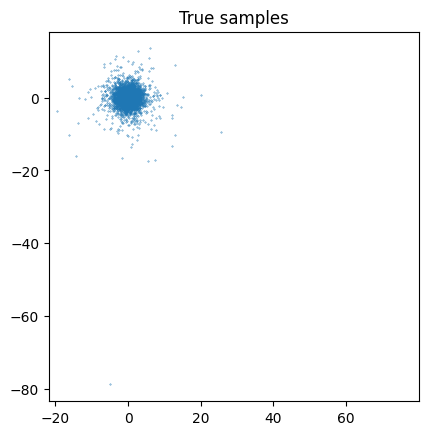

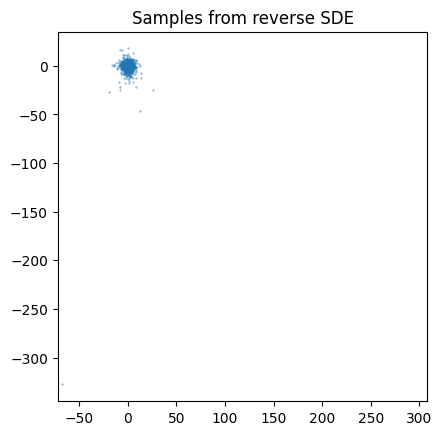

In [9]:
plt.clf()
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000, misc_params={'df':df})
ve_samples = ve_dynamics(torch.tensor(p_samples).to(dtype = torch.float32),  torch.tensor(sigma_min), torch.tensor(sigma_max))
plt.scatter(ve_samples[:,0],ve_samples[:,1],s = 0.1)
plt.axis('square')
plt.title('Samples from VE process')
plt.show()


plt.clf()
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000, misc_params={'df':df})
samples_true = torch.tensor(p_samples).to(dtype = torch.float32)
plt.scatter(samples_true[:,0],samples_true[:,1],s = 0.1)
plt.axis('square')
plt.title('True samples')
plt.show()


plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
plt.axis('square')
plt.title('Samples from reverse SDE')
plt.show()




In [10]:
filename = f"../../assets/{dataset}/ve_sgm_df{df}_{N_samples}samples.pickle"
with open(filename,"wb") as fw:
    pickle.dump([ve_samples, samples_lang] , fw)